In [27]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, Flatten, LSTM, Bidirectional
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

In [35]:
# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 478 
MAX_VOCAB_SIZE = 100000
EMBEDDING_DIM = 100
BATCH_SIZE = 500
N_EPOCHS = 20
DROPOUT = 0.0001
L2 = 1e-4

In [29]:
# train = pd.read_csv('../fnc-1-baseline-master/data/train.csv')
# test = pd.read_csv('../fnc-1-baseline-master/data/test.csv')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [18]:
train_labels = to_categorical(np.array(train['Stance']))
# test_labels = to_categorical(np.array(test['Stance']))
testing_labels = to_categorical(np.array(test['Stance']))

In [19]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train['combinedText'])
train_sequence = tokenizer.texts_to_sequences(train['combinedText'])
test_sequence = tokenizer.texts_to_sequences(test['combinedText'])

In [20]:
train_pad = pad_sequences(train_sequence, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

# pad sequences manually
# def preprocessing(headlines, bodies, stances, tokenizer):
#     # Convert the sequence of words to sequnce of indices
#     X = tokenizer.texts_to_sequences([' '.join((headline + "<>" + body)[:MAX_SENT_LEN]) for headline in headlines for body in bodies])
#     X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
#     return X, y

# X_train, y_train = preprocessing(headlines, bodies, stance, tokenizer)

In [7]:
# in_file = '../fnc-1-baseline-master/data/glove_wiki/glove.6B.100d.txt'
# out_file = '../fnc-1-baseline-master/data/glove_wiki/glove.6B.100d.word2vec.txt'

in_file = '../data/glove/glove.6B.100d.txt'
out_file = '../data/glove/glove.6B.100d.word2vec.txt'

glove2word2vec(in_file, out_file)
w2v = KeyedVectors.load_word2vec_format(out_file, binary=False)


In [34]:
# inp = '../fnc-1-baseline-master/data/glove_twitter/glove.27B.200d.txt'
# outp = '../fnc-1-baseline-master/data/glove_twitter/glove.27B.200d.word2vec.txt'

# glove2word2vec(inp, outp)
# w2v_twitter = KeyedVectors.load_word2vec_format(outp, binary=False)


In [8]:
vocab = tokenizer.word_index.keys()
# Add one because index 0 is reserved and isn't assigned to any word
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))

embedding_matrix[0] = np.random.random((1, EMBEDDING_DIM))
for i, word in enumerate(vocab, 1):
    try:
        embedding_matrix[i] = w2v[word]
    except KeyError as e:
        embedding_matrix[i] = np.random.random((1, EMBEDDING_DIM))
        
# from a3
# embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM))   
# for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
#     try:
#         embeddings_vector = word_embeddings[word]
#     except KeyError:
#         embeddings_vector = None
#     if embeddings_vector is not None:
#         embeddings_matrix[i] = embeddings_vector


In [21]:
train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, train_labels, random_state = 42, test_size = 0.15)


In [45]:
len(val_labels)

6372

In [85]:
keras.backend.clear_session()

# LSTM
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=EMBEDDING_DIM, 
                    input_length = MAX_SENT_LEN,
                    weights = [embedding_matrix], 
                    trainable=False, 
                    name='word_embedding_layer',
                    mask_zero=True))

model.add(Bidirectional(LSTM(120, return_sequences = False)))
model.add(Flatten())
model.add(Dropout(DROPOUT))

model.add(Dense(4, activation = 'softmax', name='softmax_output_layer'))

# model.add(Dense(2, activation = 'softmax', name='softmax_output_layer', activity_regularizer=l2(L2)))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_embedding_layer (Embed  (None, 30, 100)          2787600   
 ding)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 240)              212160    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 softmax_output_layer (Dense  (None, 4)                964       
 )                                                               
                                                        

In [86]:
fit = model.fit(train_pad, train_labels, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_pad, val_labels))

Epoch 1/20
43/43 [==============================] - 16s 258ms/step - loss: 0.8021 - accuracy: 0.7302 - val_loss: 0.7522 - val_accuracy: 0.7393
Epoch 2/20
43/43 [==============================] - 9s 216ms/step - loss: 0.7433 - accuracy: 0.7366 - val_loss: 0.7095 - val_accuracy: 0.7488
Epoch 3/20
43/43 [==============================] - 9s 217ms/step - loss: 0.6884 - accuracy: 0.7495 - val_loss: 0.6560 - val_accuracy: 0.7680
Epoch 4/20
43/43 [==============================] - 9s 212ms/step - loss: 0.6145 - accuracy: 0.7700 - val_loss: 0.5753 - val_accuracy: 0.7876
Epoch 5/20
43/43 [==============================] - 10s 221ms/step - loss: 0.5268 - accuracy: 0.8025 - val_loss: 0.5002 - val_accuracy: 0.8100
Epoch 6/20
43/43 [==============================] - 9s 218ms/step - loss: 0.4587 - accuracy: 0.8273 - val_loss: 0.4554 - val_accuracy: 0.8306
Epoch 7/20
43/43 [==============================] - 9s 220ms/step - loss: 0.3887 - accuracy: 0.8559 - val_loss: 0.3977 - val_accuracy: 0.8514
Epoc

In [87]:
 _, accuracy = model.evaluate(test_pad, test_labels, batch_size=BATCH_SIZE)
print("Test Set Accuracy = {:.4f}".format(accuracy))

26/26 [==============================] - 2s 88ms/step - loss: 1.4364 - accuracy: 0.7074
Test Set Accuracy = 0.7074


In [ ]:
### Glove 200: 65%
### Twitter 200: 62%

### Max sentence length = 100
### Twitter 200: 62%, VAL ACCURACY ~87%
### Glove 200: 70%, val accuracy 82-85%

### Max vocab size
### Glove 200: 69.38%, val accuracy 82-88%
### Glove 100: 70%

### Bidirectional LSTM
### Glove 100: 72.8%, val accuracy 89-94%

### Max sentence length = 50
### Glove 100: 72.8%

### Batch Size = 2000 (previously 250)
### Glove 100: 73.46%

### Batch size = 500
### Glove 100: 73.9

### Batch size = 100
### Glove 100: 73.5%%

### Epochs = 20
### Glove 100: 73.9%

### Max sentences = 30
### Glove 100: 70.7%


In [30]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


oversample = RandomOverSampler(sampling_strategy={0:round(36545*0.25), 1: round(36545*0.5), 2: round(36545*0.5)})
undersample = RandomUnderSampler(sampling_strategy={3: round(36545*0.5)})

train_over, training_over_labels = oversample.fit_resample(train, train['Stance'])

print(Counter(training_over_labels))

train_combined_sampling, training_combined_sampling_labels = undersample.fit_resample(train_over, training_over_labels)

print(f"Combined:{Counter(training_combined_sampling_labels)}")

training_combined_labels = to_categorical(np.array(training_combined_sampling_labels))
testing_labels = to_categorical(np.array(test['Stance']))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combinedText'])
test_sequence = tokenizer.texts_to_sequences(test['combinedText'])
train_combined_sequence = tokenizer.texts_to_sequences(train_combined_sampling['combinedText'])

Counter({3: 36545, 1: 18272, 2: 18272, 0: 9136})
Combined:Counter({1: 18272, 2: 18272, 3: 18272, 0: 9136})


In [31]:
in_file = '../data/glove/glove.6B.100d.txt'
out_file = '../data/glove/glove.6B.100d.word2vec.txt'

glove2word2vec(in_file, out_file)
w2v = KeyedVectors.load_word2vec_format(out_file, binary=False)

In [32]:
vocab = tokenizer.word_index.keys()
# Add one because index 0 is reserved and isn't assigned to any word
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))

embedding_matrix[0] = np.random.random((1, EMBEDDING_DIM))
for i, word in enumerate(vocab, 1):
    try:
        embedding_matrix[i] = w2v[word]
    except KeyError as e:
        embedding_matrix[i] = np.random.random((1, EMBEDDING_DIM))

In [36]:
train_combined_pad = pad_sequences(train_combined_sequence, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
test_pad = pad_sequences(test_sequence, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
train_combined_pad, val_combined_pad, train_combined_labels, val_combined_labels = train_test_split(train_combined_pad, training_combined_labels, random_state = 42, test_size = 0.15)


In [ ]:
# LSTM
epochs = [20]
batch_sizes = [100, 500]
dropouts = [0.2, 0.3, 0.4]

best_model = Sequential()
# best_accuracy = 0
best_accuracy = 0.7060
for epoch in epochs:
    for batch_size in batch_sizes:
        for dropout in dropouts:
            if (epoch !=10 or (epoch == 10 and batch_size == 1000) or (epoch == 10 and batch_size == 2000)):
                if (epoch == 10 and batch_size==1000 and dropout == 0.2): continue
                keras.backend.clear_session()

                print(f"Current Model is: epoch={epoch}, batch_size={batch_size}, and dropout={dropout}")

                model = Sequential()

                model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                                    output_dim=EMBEDDING_DIM, 
                                    input_length = MAX_SENT_LEN,
                                    weights = [embedding_matrix], 
                                    trainable=False, 
                                    name='word_embedding_layer',
                                    mask_zero=True))

                model.add(Bidirectional(LSTM(120, return_sequences = False)))
                # model.add(Flatten())
                model.add(Dropout(dropout))

                model.add(Dense(4, activation = 'softmax', name='softmax_output_layer'))

                # model.add(Dense(2, activation = 'softmax', name='softmax_output_layer', activity_regularizer=l2(L2)))

                model.compile(loss='categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

    #             model.summary()
                fit = model.fit(train_combined_pad, train_combined_labels, epochs=epoch, batch_size=batch_size, validation_data=(val_combined_pad, val_combined_labels))
                _, accuracy = model.evaluate(test_pad, testing_labels, batch_size=batch_size)
                print("Test Set Accuracy = {:.4f}".format(accuracy))

                if (accuracy > best_accuracy):
                    best_accuracy = accuracy
                    best_model = model
                    best_model_string = f"Best Model has epoch={epoch}, batch_size={batch_size}, and dropout={dropout}"
                    print(best_model_string) 

Current Model is: epoch=20, batch_size=100, and dropout=0.2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 54359 samples, validate on 9593 samples
Epoch 1/20
54359/54359 [==============================] - 431s 8ms/step - loss: 0.9748 - accuracy: 0.5775 - val_loss: 0.6769 - val_accuracy: 0.7268
Epoch 2/20
54359/54359 [==============================] - 424s 8ms/step - loss: 0.5230 - accuracy: 0.7996 - val_loss: 0.4293 - val_accuracy: 0.8432
Epoch 3/20
54359/54359 [==============================] - 422s 8ms/step - loss: 0.3145 - accuracy: 0.8873 - val_loss: 0.2705 - val_accuracy: 0.9044
Epoch 4/20
54359/54359 [==============================] - 423s 8ms/step - loss: 0.1997 - accuracy: 0.9324 - val_loss: 0.1899 - val_accuracy: 0.9371
Epoch 5/20
54359/54359 [==============================] - 421s 8ms/step - loss: 0.1388 - accuracy: 0.9548 - val_loss: 0.1425 - val_accuracy: 0.9542
Epoch 6/20
54359/54359 [==============================] 

In [ ]:
# RUNNING AND SAVING THE BEST TRAINED MODELS

In [22]:
# V1
keras.backend.clear_session()

# LSTM
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=EMBEDDING_DIM, 
                    input_length = MAX_SENT_LEN,
                    weights = [embedding_matrix], 
                    trainable=False, 
                    name='word_embedding_layer',
                    mask_zero=True))

model.add(Bidirectional(LSTM(120, return_sequences = False)))
model.add(Dropout(DROPOUT))

model.add(Dense(4, activation = 'softmax', name='softmax_output_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit = model.fit(train_pad, train_labels, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_pad, val_labels))

y_predict, accuracy = model.evaluate(test_pad, testing_labels, batch_size=BATCH_SIZE)
print("Test Set Accuracy = {:.4f}".format(accuracy))
model.save('../data/LSTM_v1.model')


Train on 42476 samples, validate on 7496 samples
Epoch 1/20
42476/42476 [==============================] - 65s 2ms/step - loss: 0.7950 - accuracy: 0.7244 - val_loss: 0.7241 - val_accuracy: 0.7491
Epoch 2/20
42476/42476 [==============================] - 63s 1ms/step - loss: 0.6974 - accuracy: 0.7483 - val_loss: 0.6459 - val_accuracy: 0.7561
Epoch 3/20
42476/42476 [==============================] - 63s 1ms/step - loss: 0.6151 - accuracy: 0.7668 - val_loss: 0.5593 - val_accuracy: 0.7880
Epoch 4/20
42476/42476 [==============================] - 62s 1ms/step - loss: 0.5090 - accuracy: 0.8058 - val_loss: 0.4719 - val_accuracy: 0.8295
Epoch 5/20
42476/42476 [==============================] - 62s 1ms/step - loss: 0.4245 - accuracy: 0.8362 - val_loss: 0.4015 - val_accuracy: 0.8527
Epoch 6/20
42476/42476 [==============================] - 62s 1ms/step - loss: 0.3506 - accuracy: 0.8670 - val_loss: 0.3503 - val_accuracy: 0.8715
Epoch 7/20
42476/42476 [==============================] - 62s 1ms/st

In [37]:
# V2
keras.backend.clear_session()

model = Sequential()
epoch = 20
batch_size = 100
dropout = 0.4
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=EMBEDDING_DIM, 
                    input_length = 478,
                    weights = [embedding_matrix], 
                    trainable=False, 
                    name='word_embedding_layer',
                    mask_zero=True))

model.add(Bidirectional(LSTM(120, return_sequences = False)))
model.add(Dropout(dropout))

model.add(Dense(4, activation = 'softmax', name='softmax_output_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit = model.fit(train_combined_pad, train_combined_labels, epochs=epoch, batch_size=batch_size, validation_data=(val_combined_pad, val_combined_labels))
_, accuracy = model.evaluate(test_pad, testing_labels, batch_size=batch_size)
print("Test Set Accuracy = {:.4f}".format(accuracy))
model.save('../data/LSTM_v2.model')

Train on 54359 samples, validate on 9593 samples
Epoch 1/20
54359/54359 [==============================] - 285s 5ms/step - loss: 1.0052 - accuracy: 0.5642 - val_loss: 0.7229 - val_accuracy: 0.7152
Epoch 2/20
54359/54359 [==============================] - 285s 5ms/step - loss: 0.5452 - accuracy: 0.7921 - val_loss: 0.4342 - val_accuracy: 0.8398
Epoch 3/20
54359/54359 [==============================] - 285s 5ms/step - loss: 0.3315 - accuracy: 0.8833 - val_loss: 0.3290 - val_accuracy: 0.8866
Epoch 4/20
54359/54359 [==============================] - 285s 5ms/step - loss: 0.2240 - accuracy: 0.9244 - val_loss: 0.2033 - val_accuracy: 0.9333
Epoch 5/20
54359/54359 [==============================] - 285s 5ms/step - loss: 0.1539 - accuracy: 0.9504 - val_loss: 0.1735 - val_accuracy: 0.9467
Epoch 6/20
54359/54359 [==============================] - 285s 5ms/step - loss: 0.1177 - accuracy: 0.9621 - val_loss: 0.1494 - val_accuracy: 0.9549
Epoch 7/20
54359/54359 [==============================] - 285s 

In [40]:
y_predict = model.predict(test_pad)
y_pred_competition = y_predict.argmax(axis=-1)
y_classes = []

for i in range(len(y_pred_competition)):
    if y_pred_competition[i] == 0: y_classes.append("disagree")
    
    if y_pred_competition[i] == 1: y_classes.append("agree")
    
    if y_pred_competition[i] == 2: y_classes.append("discuss")
    
    if y_pred_competition[i] == 3: y_classes.append("unrelated")
    
answers = pd.DataFrame()
answers['Headline'] = test['Headline']
answers['Body ID'] = test['Body ID']
answers['Stance'] = y_classes
answers.to_csv('../data/answer_LSTM_v2.csv', index=False, encoding='utf-8')


Accuracy: 0.6992484161649549
Precision: [0.07622505 0.25904366 0.45122457 0.84647656]
Recall: [0.06025825 0.32737782 0.48700717 0.81372282]
F1_Scores: [0.06730769 0.28922934 0.46843353 0.82977659]


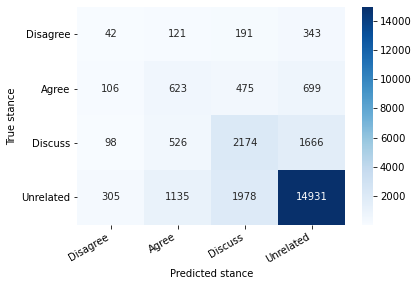

In [41]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

class_names=['Disagree', 'Agree', 'Discuss', 'Unrelated']
cm = confusion_matrix(test['Stance'], y_pred_competition)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

accuracy = accuracy_score(test['Stance'], y_pred_competition)
print(f'Accuracy: {accuracy}')

precision = precision_score(test['Stance'], y_pred_competition, average=None)
print(f'Precision: {precision}')

recall = recall_score(test['Stance'], y_pred_competition, average=None)
print(f'Recall: {recall}')

f1_scores=f1_score(test['Stance'], y_pred_competition, average=None)
print(f'F1_Scores: {f1_scores}')

In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
